In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df=pd.read_csv('Clean_1.csv')

In [ ]:
df.head()

,Person_ID,Gender,Age,Occupation,Job_category,Sleep_Duration,Quality_of_Sleep,Physical_Activity_Level,Stress_Level,BMI_Category,Weight_Category,Systolic_Blood_Pressure,Diastolic_Blood_Pressure,Heart_Rate,Daily_Steps,Sleep_Disorder,Timestamp
0,1,Male,27,Software Engineer,Science and Technology,6.1,6,42,6,Overweight,2,126,83,77,4200,NaN,2025-03-08 11:12:00
1,2,Male,28,Doctor,Healthcare,6.2,6,60,8,Normal,1,125,80,75,10000,NaN,2025-04-13 17:14:00
2,3,Male,28,Doctor,Healthcare,6.2,6,60,8,Normal,1,125,80,75,10000,NaN,2025-07-26 10:59:00
3,4,Male,28,Sales Representative,Business Management,5.9,4,30,8,Obese,3,140,90,85,3000,Sleep Apnea,2025-01-27 16:17:00
4,5,Male,28,Sales Representative,Business Management,5.9,4,30,8,Obese,3,140,90,85,3000,Sleep Apnea,2025-01-29 03:46:00


In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(['Person_ID', 'Timestamp'])



In [ ]:
# Keep only ID, Sort, and Numerical columns for feature extraction
cols_to_keep = [
    'Person_ID', 'Timestamp', 'Sleep_Duration', 'Quality_of_Sleep',
    'Physical_Activity_Level', 'Stress_Level', 'Systolic_Blood_Pressure',
    'Diastolic_Blood_Pressure', 'Heart_Rate', 'Daily_Steps'
]
tsfresh_df = extract_features(df[cols_to_keep], column_id='Person_ID', column_sort='Timestamp')

Feature Extraction: 100%|██████████| 40/40 [00:06<00:00,  6.30it/s]


In [ ]:
tsfresh_df = tsfresh_df.fillna(0)

In [ ]:
from prophet import Prophet

def run_prophet(df, value_col):
    temp = df[['Timestamp', value_col]].rename(
        columns={'Timestamp': 'ds', value_col: 'y'}
    )

    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True
    )

    model.fit(temp)
    forecast = model.predict(temp)

    return forecast


In [ ]:
prophet_steps = run_prophet(df.iloc[0:2], 'Daily_Steps')
prophet_hr = run_prophet(df.iloc[0:2], 'Heart_Rate')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.


In [ ]:
from sklearn.preprocessing import StandardScaler

X = tsfresh_df.values
X_scaled = StandardScaler().fit_transform(X)


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
tsfresh_df['cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=2.0, min_samples=10)
tsfresh_df['dbscan_cluster'] = db.fit_predict(X_scaled)


In [ ]:
from prophet import Prophet

def prophet_model(df, col):
    temp = df[['timestamp', col]].rename(
        columns={'timestamp': 'ds', col: 'y'}
    )

    model = Prophet(daily_seasonality=True)
    model.fit(temp)
    return model.predict(temp)


In [ ]:
user_id = 1
user_df = df[df['Person_ID'] == user_id].copy()
user_df = user_df.sort_values('Timestamp')


In [ ]:
from prophet import Prophet

def prophet_model(df, value_col):
    temp = df[['Timestamp', value_col]].rename(
        columns={'Timestamp': 'ds', value_col: 'y'}
    )

    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False
    )

    model.fit(temp)
    forecast = model.predict(temp)

    # Merge actual values back
    forecast = forecast.merge(
        temp[['ds', 'y']],
        on='ds',
        how='left'
    )

    return forecast

In [ ]:
forecast_daily_steps = prophet_model(df.iloc[0:2], 'Daily_Steps')
display(forecast_daily_steps.head())

INFO:prophet:n_changepoints greater than number of observations. Using 0.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2025-03-08 11:12:00,-6820.509,4200.000090,4200.000100,-6820.509,-6820.509,11020.509095,11020.509095,11020.509095,-20631.666756,-20631.666756,-20631.666756,31652.175851,31652.175851,31652.175851,0.0,0.0,0.0,4200.000095,4200
1,2025-04-13 17:14:00,-20013.626,9999.999213,9999.999223,-20013.626,-20013.626,30013.625218,30013.625218,30013.625218,-22527.872814,-22527.872814,-22527.872814,52541.498032,52541.498032,52541.498032,0.0,0.0,0.0,9999.999218,10000


In [ ]:
from prophet import Prophet

def prophet_model(df, value_col):
    temp = df[['timestamp', value_col]].rename(
        columns={'timestamp': 'ds', value_col: 'y'}
    )

    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False
    )

    model.fit(temp)
    forecast = model.predict(temp)

    # Merge actual values back
    forecast = forecast.merge(
        temp[['ds', 'y']],
        on='ds',
        how='left'
    )

    return forecast


In [ ]:
from prophet import Prophet
import pandas as pd

df_prophet = df.rename(columns={
    "Timestamp": "ds",
    "Heart_Rate": "y"
})

df_prophet["ds"] = pd.to_datetime(df_prophet["ds"]).dt.tz_localize(None)

model = Prophet()
model.fit(df_prophet)
future = model.make_future_dataframe(periods=10, freq="T")
forecast = model.predict(future)

forecast = forecast.merge(
    df_prophet[['ds', 'y']],
    on='ds',
    how='left'
)

forecast['residual'] = forecast['y'] - forecast['yhat']

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


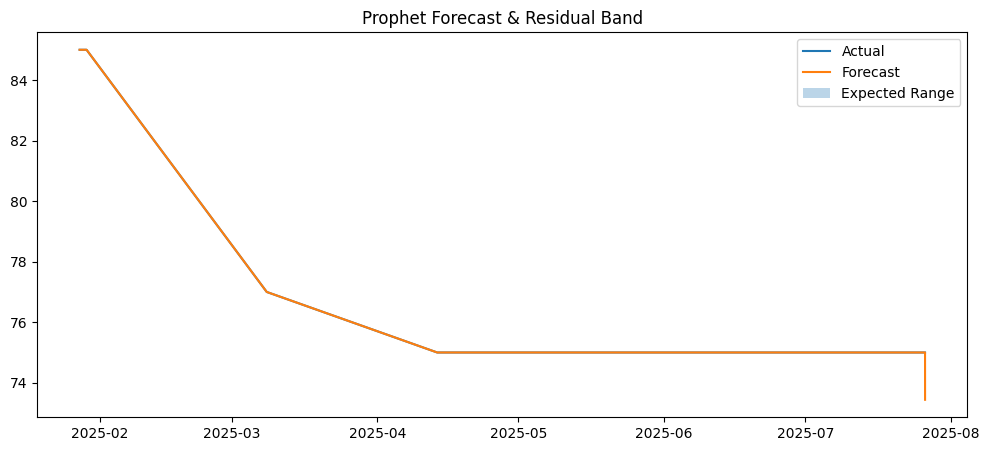

In [ ]:
import matplotlib.pyplot as plt

# Calculate residual standard deviation and thresholds
residual_std = forecast['residual'].std()
forecast['upper_threshold'] = forecast['yhat'] + 3 * residual_std
forecast['lower_threshold'] = forecast['yhat'] - 3 * residual_std

plt.figure(figsize=(12,5))
plt.plot(forecast['ds'], forecast['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.fill_between(
    forecast['ds'],
    forecast['lower_threshold'],
    forecast['upper_threshold'],
    alpha=0.3,
    label='Expected Range'
)
plt.legend()
plt.title("Prophet Forecast & Residual Band")
plt.show()

In [ ]:
residual_std = forecast['residual'].std()

forecast['upper_threshold'] = forecast['yhat'] + 3 * residual_std
forecast['lower_threshold'] = forecast['yhat'] - 3 * residual_std


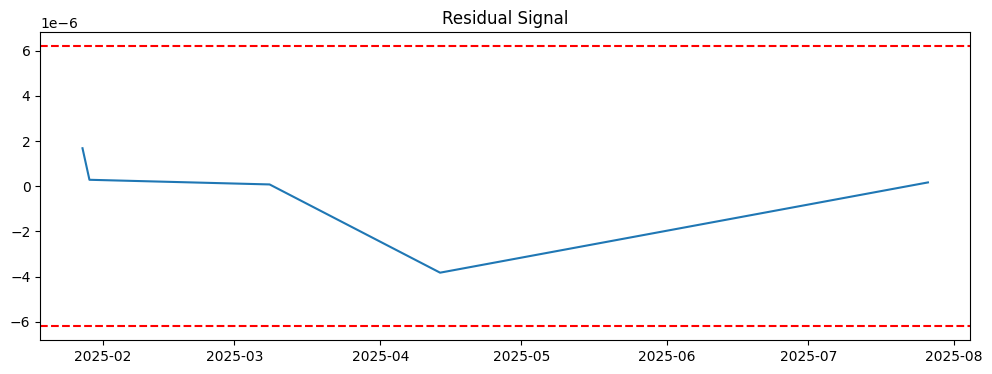

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(forecast['ds'], forecast['residual'])
plt.axhline(3*residual_std, color='red', linestyle='--')
plt.axhline(-3*residual_std, color='red', linestyle='--')
plt.title("Residual Signal")
plt.show()


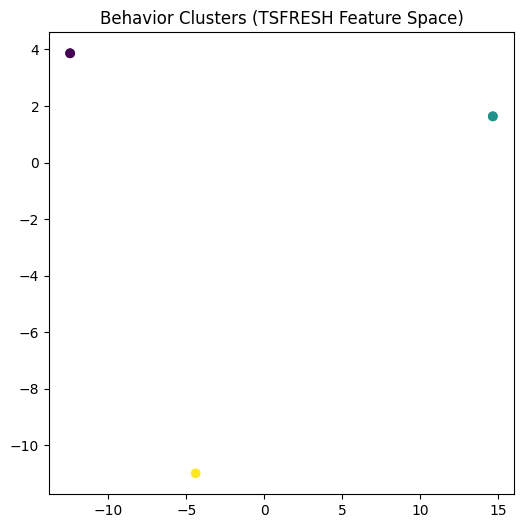

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=tsfresh_df['cluster'])
plt.title("Behavior Clusters (TSFRESH Feature Space)")
plt.show()
